In [174]:
import os
import numpy as np
from chainer import Chain
import chainer.links as L
import glob
import chainer
from chainer import function
from PIL import Image

In [171]:
vgg = L.VGG16Layers()
convert_image = chainer.links.model.vision.vgg.prepare

In [5]:
def cos_sim_matrix(matrix):
  d = matrix @ matrix.T
  norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
  return d / norm /norm.T

In [82]:
def read_image_as_array(path, dtype=np.float32):
  f = Image.open(path)
  image = np.asarray(f, dtype=dtype)
  return convert_image(image)

def read_image_as_array_croped(path, dtype=np.float32):
  img = utils.read_image(path, color=True)
  bboxes, labels, scores = model.predict([img])
  #vis_bbox(img, bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)
  im = Image.open(path)
  for bbox, label in zip(bboxes, labels):
    bbox = bbox[0][[1,0,3,2]]
    crop_img = im.crop(bbox)
    return convert_image(np.asarray(crop_img, dtype=dtype))
  
data_path = glob.glob("./data/*")
data = np.asarray([read_image_as_array_croped(path) for path in data_path])

In [83]:
with function.no_backprop_mode():
  h = vgg(data, layers=['fc6'])

In [84]:
matrix = h['fc6'].data

In [85]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [90]:
for i, j in zip(data_path, matrix):
  print(i)
  print(cos_sim(matrix[6], j))

./data\1.jpg
0.14752
./data\10.jpg
0.27529
./data\11.jpg
0.0584177
./data\12.jpg
0.265971
./data\13.jpeg
0.0702136
./data\2.jpg
0.18702
./data\3.jpg
1.0
./data\4.jpg
0.237149
./data\5.jpg
0.193742
./data\6.jpg
0.186566
./data\7.jpg
0.214589
./data\8.jpg
0.190998
./data\9.jpg
0.228392


In [11]:
%matplotlib inline
import chainercv
from chainercv import utils
from chainercv.datasets import voc_bbox_label_names
from chainercv.visualizations import vis_bbox
import matplotlib.pyplot as plt

model = chainercv.links.SSD512(n_fg_class=len(voc_bbox_label_names), pretrained_model='voc0712')

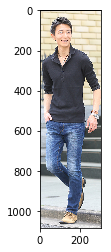

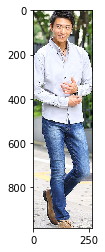

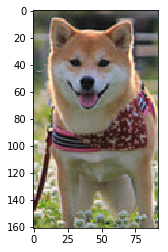

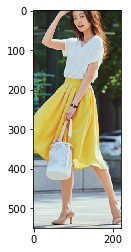

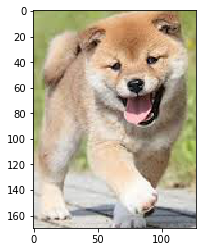

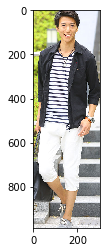

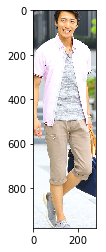

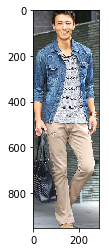

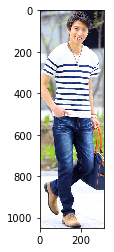

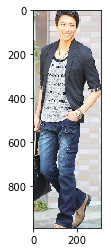

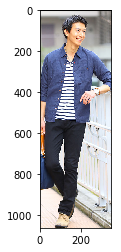

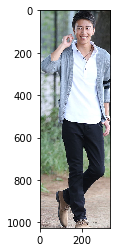

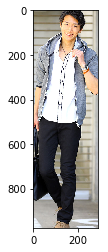

In [80]:
for path in data_path:
  img = utils.read_image(path, color=True)
  bboxes, labels, scores = model.predict([img])
  #vis_bbox(img, bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)
  im = Image.open(path)
  for bbox, label in zip(bboxes, labels):
    bbox = bbox[0][[1,0,3,2]]
    crop_img = im.crop(bbox)
    plt.imshow(np.array(crop_img))
    plt.show()

In [12]:
import os
import argparse
import copy
import warnings
import json
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import chainer
from chainer.datasets import TransformDataset
from chainer.optimizer import WeightDecay
from chainer import serializers
from chainer import training
from chainer.training import extensions
from chainer.training import triggers
from chainer.links.model.vision import resnet

import chainercv
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links.model.ssd import GradientScaling
from chainercv.links.model.ssd import multibox_loss
from chainercv import transforms

from chainercv.links.model.ssd import random_crop_with_bbox_constraints
from chainercv.links.model.ssd import random_distort
from chainercv.links.model.ssd import resize_with_random_interpolation


from chainercv.links import SSD300
from chainercv.links import SSD512
from chainercv.utils import read_image

In [2]:
class MultiboxTrainChain(chainer.Chain):

    def __init__(self, model, alpha=1, k=3):
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def __call__(self, imgs, gt_mb_locs, gt_mb_labels):
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = multibox_loss(
            mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss

        chainer.reporter.report(
            {'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss},
            self)

        return loss

In [3]:
class Transform(object):

    def __init__(self, coder, size, mean):
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        # There are five data augmentation steps
        # 1. Color augmentation
        # 2. Random expansion
        # 3. Random cropping
        # 4. Resizing with random interpolation
        # 5. Random horizontal flipping

        img, bbox, label = in_data

        # 1. Color augmentation
        img = random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = transforms.random_expand(
                img, fill=self.mean, return_param=True)
            bbox = transforms.translate_bbox(
                bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # 3. Random cropping
        img, param = random_crop_with_bbox_constraints(
            img, bbox, return_param=True)
        bbox, param = transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]

        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = resize_with_random_interpolation(img, (self.size, self.size))
        bbox = transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = transforms.random_flip(
            img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(
            bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

In [146]:
import chainer 
from pathlib import Path

label_names = ('tops', 'bottoms')

class BBoxDataset(chainer.dataset.DatasetMixin):
  def __init__(self, data_dir='data', split='train'):
    id_list_file = os.path.join(
      data_dir, 'ImageSets/{0}.txt'.format(split))
    self.ids = [id_.strip() for id_ in open(id_list_file)]
    self.data_dir = data_dir
    
  def __len__(self):
    return len(self.ids)
  
  def get_example(self, i):
    id_ = self.ids[i]
    
    json_path = Path('data', 'Annotations', 'annotation.json')
    json_loaded = json.load(json_path.open('r'))
    
    jpg_path = Path('data', 'images', id_ + '.jpg')
    jpg_size = jpg_path.stat().st_size
    anno = json_loaded[id_ + '.jpg' + str(jpg_size)]

    bbox = []
    label = []
    for obj in anno['regions']:
      bndbox_anno = obj['shape_attributes']
      bbox.append([
        bndbox_anno['y'],
        bndbox_anno['x'],
        bndbox_anno['y'] + bndbox_anno['height'],
        bndbox_anno['x'] + bndbox_anno['width']])
      name = obj['region_attributes']['type'].lower().strip()
      label.append(label_names.index(name))
    bbox = np.stack(bbox).astype(np.float32)
    label = np.stack(label).astype(np.int32)
    img = read_image(jpg_path.as_posix(), color=True)
    return img, bbox, label

In [150]:
gpu = 0

def main():
  model = SSD300(n_fg_class=len(label_names),
    pretrained_model='via_model')  
  model.use_preset('evaluate')
  train_chain = MultiboxTrainChain(model)
  if gpu >= 0:
    chainer.cuda.get_device_from_id(gpu).use()
    model.to_gpu()

  train = TransformDataset(
    BBoxDataset(split='train'),
    Transform(model.coder, model.insize, model.mean))
  train_iter = chainer.iterators.SerialIterator(train, 10)

  test = BBoxDataset(split='test')
  test_iter = chainer.iterators.SerialIterator(
  test, 2, repeat=False, shuffle=False)

  optimizer = chainer.optimizers.MomentumSGD(lr=0.0001)
  optimizer.setup(train_chain)
  for param in train_chain.params():
    if param.name == 'b':
      param.update_rule.add_hook(GradientScaling(2))
    else:
      param.update_rule.add_hook(WeightDecay(0.0005))

  updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu)
  trainer = training.Trainer(updater, (1000, 'iteration'), 'result')
  trainer.extend(
    DetectionVOCEvaluator(
    test_iter, model, use_07_metric=True,
    label_names=label_names),
    trigger=(10, 'iteration'))

  log_interval = 10, 'iteration'
  trainer.extend(extensions.LogReport(trigger=log_interval))
  trainer.extend(extensions.observe_lr(), trigger=log_interval)
  trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'lr',
    'main/loss', 'main/loss/loc', 'main/loss/conf',
    'validation/main/map']),
    trigger=log_interval)
  trainer.extend(extensions.ProgressBar(update_interval=10))
  trainer.run()
  serializers.save_npz('via_model', model)

In [151]:
main()

epoch       iteration   lr          main/loss   main/loss/loc  main/loss/conf  validation/main/map
3           10          0.0001      1.70457     0.522415       1.18216         1                    
     total [..................................................]  1.00%
this epoch [######################............................] 44.83%
        10 iter, 3 epoch / 1000 iterations
       inf iters/sec. Estimated time to finish: 0:00:00.
6           20          0.0001      1.66507     0.497589       1.16748         1                    
     total [#.................................................]  2.00%
this epoch [############################################......] 89.66%
        20 iter, 6 epoch / 1000 iterations
    2.1026 iters/sec. Estimated time to finish: 0:07:46.088004.
10          30          0.0001      1.77776     0.56835        1.20941         1                    
     total [#.................................................]  3.00%
this epoch [#################.......

In [96]:
hoge = BBoxDataset(split='test')

In [97]:
for i in hoge[0]:
  print(i.shape)

(3, 427, 320)
(2, 4)
(2,)


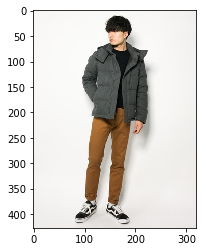

In [99]:
plt.imshow(np.asarray(hoge[1][0]).transpose(1,2,0) / 255)
plt.show()

In [78]:
print(hoge[0][0].shape)

(3, 300, 300)


In [152]:
model = SSD300(n_fg_class=len(label_names),
    pretrained_model='via_model')
bboxes, labels, scores = model.predict([hoge[1][0]])

In [101]:
print(bboxes)

[array([[  52.48472595,   91.35443115,  226.87858582,  232.51568604],
       [ 185.55116272,   95.59370422,  378.9460144 ,  196.43518066]], dtype=float32)]


In [102]:
print(len(labels[0]))

2


In [103]:
print(scores)

[array([ 0.99876362,  0.99607438], dtype=float32)]


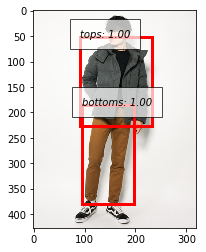

In [104]:
from chainercv.visualizations import vis_bbox
vis_bbox(hoge[1][0], bboxes[0], labels[0], scores[0], label_names=label_names)

In [168]:
import glob
import chainercv
from chainercv.visualizations import vis_bbox
from chainercv import utils
from PIL import Image
data_path = glob.glob("./data/images/*")
print(data_path)

['./data/images\\20171129155138759_320.jpg', './data/images\\20171129155257825_320.jpg', './data/images\\20171129155421084_320.jpg', './data/images\\20171129155622425_320.jpg', './data/images\\20171129160029199_320.jpg', './data/images\\20171129162456811_320.jpg', './data/images\\20171129170306746_320.jpg', './data/images\\20171129170802554_320.jpg', './data/images\\20171130114536156_320.jpg', './data/images\\20171130114708149_320.jpg', './data/images\\20171130114819407_320.jpg', './data/images\\20171130114933923_320.jpg', './data/images\\20171130115102632_320.jpg', './data/images\\20171130115224212_320.jpg', './data/images\\20171130115344043_320.jpg', './data/images\\20171130115518249_320.jpg', './data/images\\20171130131519115_320.jpg', './data/images\\20171130131708916_320.jpg', './data/images\\20171130131835114_320.jpg', './data/images\\20171130142714051_320.jpg', './data/images\\20171130142844673_320.jpg', './data/images\\20171130143020235_320.jpg', './data/images\\201711301435144

0


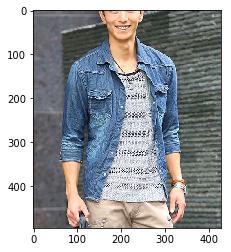

1


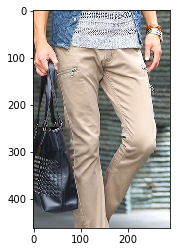

0


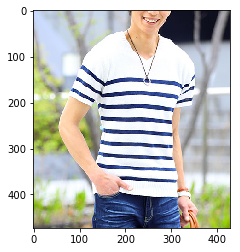

1


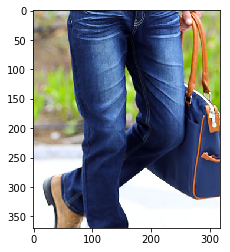

0


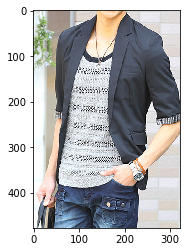

1


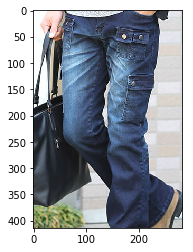

0


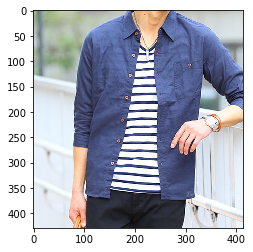

1


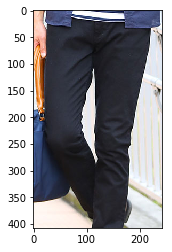

0


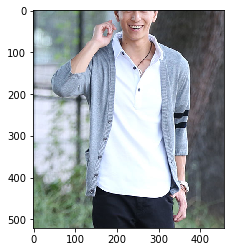

1


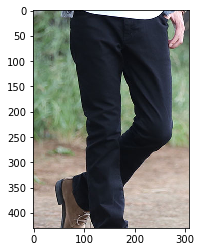

0


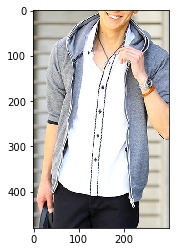

1


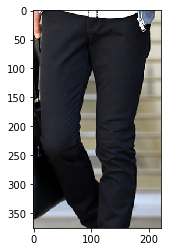

0


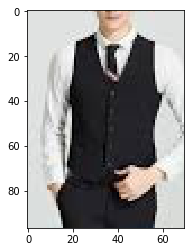

1


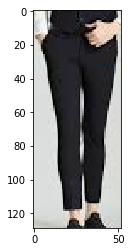

0


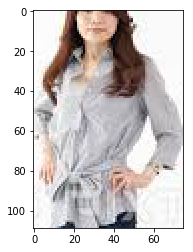

1


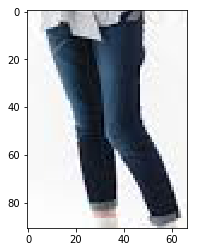

0


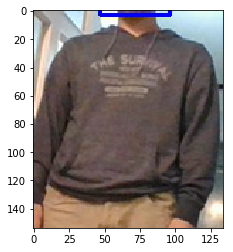

1


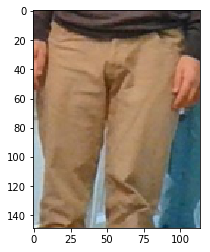

0


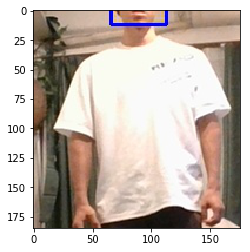

In [167]:
for path in data_path[-10:]:
  img = utils.read_image(path, color=True)
  bboxes, labels, scores = model.predict([img])
  #vis_bbox(img, bboxes[0], labels[0], scores[0], label_names=label_names)
  im = Image.open(path)
  for bbox, label in zip(bboxes, labels):
    for b, l in zip(bbox, label):
      print(l)
      b = b[[1,0,3,2]]
      crop_img = im.crop(b)
      plt.imshow(np.array(crop_img))
      plt.show()

In [145]:
with open("data/Annotations/annotation.json", mode="r") as f:
  json_list = json.load(f)
for item in json_list.items():
  if item[1]['regions']:
    print(item[0].split(".")[0])

20171225173956994_320
20171225173645827_320
20171211171248123_320
20171225162510669_320
20171211170730501_320
20171222162756284_320
20171225162354653_320
20171222122200194_320
20171225164915194_320
20171211162805156_320
20171225145436707_320
20171225114735520_320
20171225162848182_320
20171211171436296_320
20171225173430003_320
20171222124202331_320
20171225121236091_320
yamatoshi
20171222161845443_320
20171222161713069_320
20171225164620663_320
20171222122020879_320
20171225144932759_320
20171211170919342_320
20171225145157145_320
20171211162946402_320
20171211170332923_320
20171222162437897_320
20171225173534081_320
20171225164759966_320
20171225162710428_320


In [183]:
from annoy import AnnoyIndex

annoy_model = AnnoyIndex(4096)
with function.no_backprop_mode():
  for i, path in enumerate(data_path):
    img = utils.read_image(path, color=True)
    bboxes, labels, scores = model.predict([img])
    #vis_bbox(img, bboxes[0], labels[0], scores[0], label_names=label_names)
    im = Image.open(path)
    for bbox, label in zip(bboxes, labels):
      for b, l in zip(bbox, label):
        if l==0:
          b = b[[1,0,3,2]]
          crop_img = im.crop(b)
          h = vgg(convert_image(np.asarray(crop_img, dtype=np.float32))[np.newaxis,:,:,:], layers=['fc6'])
          annoy_model.add_item(i, h['fc6'][0].data)
annoy_model.build(1000)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


True

[87, 128, 7, 29, 85]
./data/images\20171211121045945_320.jpg
./data/images\yamatoshi.jpg
./data/images\20171129170802554_320.jpg
./data/images\20171130162916231_320.jpg
./data/images\20171211115638964_320.jpg


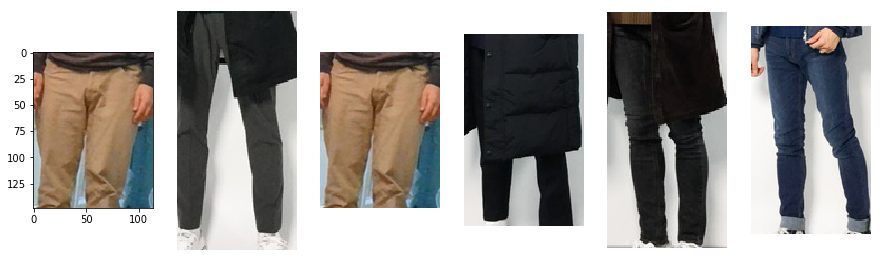

In [230]:
fig = plt.figure(figsize=(15, 15))
query_img = utils.read_image("data/test/yamatoshi.jpg", color=True)
im = Image.open("data/test/yamatoshi.jpg")
bboxes, labels, scores = model.predict([query_img])
with function.no_backprop_mode():
  for bbox, label in zip(bboxes, labels):
    for b, l in zip(bbox, label):
      if l==1:
        b = b[[1,0,3,2]]
        crop_img = im.crop(b)
        ax = fig.add_subplot(1, 6, 1)
        ax.imshow(np.array(crop_img))
        h = vgg(convert_image(np.asarray(crop_img, dtype=np.float32))[np.newaxis,:,:,:], layers=['fc6'])
        predict_indexes = annoy_model.get_nns_by_vector(h['fc6'][0].data, 5, search_k=-1)
        print(predict_indexes)
        
for idx, predict_index in enumerate(predict_indexes):
  neibor_image = data_path[predict_index]
  print(neibor_image)
  img = utils.read_image(neibor_image, color=True)
  bboxes, labels, scores = model.predict([img])
  im = Image.open(neibor_image)
  for bbox, label in zip(bboxes, labels):
    for b, l in zip(bbox, label):
      if l==1:
        b = b[[1,0,3,2]]
        crop_img = im.crop(b)
        ax = fig.add_subplot(1, 6, idx+2)
        ax.imshow(np.array(crop_img))
        plt.axis("off")